In [118]:
import networkx as nx
# import community as community_louvain
from community import community_louvain
import numpy as np
from collections import defaultdict

# import networkx as nx
# from community import community_louvain
# from collections import defaultdict

def comdis_attack(G):
    """
    改进的COMDis算法实现 - 基于社区的节点攻击策略
    
    参数:
        G: networkx图对象
        
    返回:
        attack_order: 节点攻击顺序列表
    """
    """严格遵循论文描述的COMDis实现"""
    attack_order = []
    remaining_G = G.copy()
    
    while True:
        # 1. 动态检测社区
        partition = community_louvain.best_partition(remaining_G)
        communities = defaultdict(list)
        for node, comm in partition.items():
            communities[comm].append(node)
        
        # 2. 构建社区图
        comm_graph = nx.Graph()
        for comm in communities:
            comm_graph.add_node(comm, size=len(communities[comm]))
        
        inter_edges = defaultdict(int)
        for u, v in remaining_G.edges():
            comm_u, comm_v = partition[u], partition[v]
            if comm_u != comm_v:
                inter_edges[(min(comm_u, comm_v), max(comm_u, comm_v))] += 1
        
        for (comm_u, comm_v), weight in inter_edges.items():
            comm_graph.add_edge(comm_u, comm_v, weight=weight)
        
        if not nx.is_connected(comm_graph):
            break  # 社区图已不连通
        
        # 3. 计算边重要性
        edge_weights = {
            (u, v): comm_graph.nodes[u]['size'] * comm_graph.nodes[v]['size'] * comm_graph[u][v]['weight']
            for u, v in comm_graph.edges()
        }
        
        if not edge_weights:
            break  # 无社区间边
            
        # 4. 攻击最重要的边
        (comm_u, comm_v) = max(edge_weights.items(), key=lambda x: x[1])[0]
        
        # 收集连接这两个社区的所有节点
        bridge_nodes = []
        for node in communities[comm_u]:
            if node in remaining_G:
                for neighbor in list(remaining_G.neighbors(node)):
                    if neighbor in remaining_G and partition[neighbor] == comm_v:
                        bridge_nodes.append(node)
                        break
        
        for node in communities[comm_v]:
            if node in remaining_G:
                for neighbor in list(remaining_G.neighbors(node)):
                    if neighbor in remaining_G and partition[neighbor] == comm_u:
                        bridge_nodes.append(node)
                        break
        
        if not bridge_nodes:
            continue
            
        # 按degree排序并攻击
        bridge_nodes.sort(key=lambda x: -remaining_G.degree(x))
        node_to_attack = bridge_nodes[0]
        attack_order.append(node_to_attack)
        remaining_G.remove_node(node_to_attack)
    
    # 5. 攻击剩余节点
    remaining_nodes = sorted(remaining_G.nodes(), key=lambda x: -remaining_G.degree(x))
    attack_order.extend(remaining_nodes)
    
    return attack_order

In [119]:
def comdise_attack(G):
    """
    COMDiSE算法实现 - 基于社区的边攻击策略
    
    参数:
        G: networkx图对象
        
    返回:
        attack_order: 边攻击顺序列表
    """
    # 1. 使用Louvain算法检测社区
    partition = community_louvain.best_partition(G)
    
    # 2. 构建社区图
    community_graph = nx.Graph()
    community_nodes = defaultdict(list)
    
    # 将节点映射到社区
    for node, comm in partition.items():
        community_nodes[comm].append(node)
    
    # 添加社区节点
    for comm in community_nodes:
        community_graph.add_node(comm, size=len(community_nodes[comm]))
    
    # 添加社区间边
    for u, v in G.edges():
        comm_u = partition[u]
        comm_v = partition[v]
        if comm_u != comm_v:
            if community_graph.has_edge(comm_u, comm_v):
                community_graph[comm_u][comm_v]['weight'] += 1
            else:
                community_graph.add_edge(comm_u, comm_v, weight=1)
    
    # 3. 计算社区边的重要性(权重)
    edge_weights = {}
    for u, v in community_graph.edges():
        # 权重 = 社区大小乘积 * 社区间连接数
        edge_weights[(u, v)] = community_graph.nodes[u]['size'] * community_graph.nodes[v]['size'] * community_graph[u][v]['weight']
    
    # 按权重排序边
    sorted_edges = sorted(edge_weights.items(), key=lambda x: -x[1])
    
    # 4. 攻击边
    attack_order = []
    remaining_G = G.copy()
    
    for (comm_u, comm_v), _ in sorted_edges:
        # 获取连接这两个社区的所有边
        inter_edges = []
        for node_u in community_nodes[comm_u]:
            if node_u in remaining_G:  # 确保节点仍在图中
                for node_v in list(remaining_G.neighbors(node_u)):  # 转换为list避免迭代时修改
                    if node_v in remaining_G and partition[node_v] == comm_v:
                        inter_edges.append((node_u, node_v))
        
        # 按节点degree之和排序这些边
        inter_edges = sorted(inter_edges, key=lambda x: -(remaining_G.degree(x[0]) + remaining_G.degree(x[1])))
        
        # 攻击这些边直到两个社区断开
        for edge in inter_edges:
            if remaining_G.has_edge(*edge):
                attack_order.append(edge)
                remaining_G.remove_edge(*edge)
                
                # 重新检查社区连接性
                current_community_graph = nx.Graph()
                current_communities = set(partition[n] for n in remaining_G.nodes())
                
                for comm in current_communities:
                    current_community_graph.add_node(comm)
                
                for u, v in remaining_G.edges():
                    comm_u = partition[u]
                    comm_v = partition[v]
                    if comm_u != comm_v:
                        if current_community_graph.has_edge(comm_u, comm_v):
                            current_community_graph[comm_u][comm_v]['weight'] += 1
                        else:
                            current_community_graph.add_edge(comm_u, comm_v, weight=1)
                
                if not nx.is_connected(current_community_graph):
                    break
    
    return attack_order

In [120]:
def evaluate_attack(G, attack_order, attack_type='node'):
    """
    评估攻击效果
    
    参数:
        G: 原始图
        attack_order: 攻击顺序(节点或边)
        attack_type: 'node'或'edge'
        
    返回:
        robustness_curve: 攻击过程中的GCC大小变化
        R_value: 鲁棒性值
    """
    if attack_type == 'node':
        temp_G = G.copy()
        robustness_curve = []
        
        for node in attack_order:
            if node in temp_G:
                temp_G.remove_node(node)
                if len(temp_G) == 0:
                    robustness_curve.append(0)
                else:
                    largest_cc = max(nx.connected_components(temp_G), key=len)
                    robustness_curve.append(len(largest_cc) / len(G))
        
        R_value = sum(robustness_curve) / len(G)
        
    elif attack_type == 'edge':
        temp_G = G.copy()
        robustness_curve = [1.0]  # 初始GCC大小为1
        
        for edge in attack_order:
            if temp_G.has_edge(*edge):
                temp_G.remove_edge(*edge)
                largest_cc = max(nx.connected_components(temp_G), key=len)
                robustness_curve.append(len(largest_cc) / len(G))
                
                # 当GCC小于10%时停止
                if robustness_curve[-1] < 0.1:
                    break
        
        # Q值: 使GCC<10%需要移除的边比例
        Q_value = len(robustness_curve) / G.number_of_edges()
        R_value = Q_value
    
    return robustness_curve, R_value

In [121]:
# # 创建一个示例图
# G = nx.karate_club_graph()

# # COMDis节点攻击
# node_attack_order = comdis_attack(G)
# node_curve, R_node = evaluate_attack(G, node_attack_order, 'node')
# print(f"COMDis R value: {R_node:.4f}")

# # # COMDiSE边攻击
# # edge_attack_order = comdise_attack(G)
# # edge_curve, Q_edge = evaluate_attack(G, edge_attack_order, 'edge')
# # print(f"COMDiSE Q value: {Q_edge:.4f}")

# # 绘制攻击曲线
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(np.linspace(0, 1, len(node_curve)), node_curve, label='COMDis (Node Attack)')
# # plt.plot(np.linspace(0, Q_edge, len(edge_curve)), edge_curve, label='COMDiSE (Edge Attack)')
# plt.xlabel('Fraction of removed elements')
# plt.ylabel('Relative size of GCC')
# plt.title('Network Robustness under COMDis and COMDiSE Attacks')
# plt.legend()
# plt.grid()
# plt.show()

In [122]:
#read network
def datapro(todraw, weight_field = 'weight', exist = False):
    #exist: edges (T) or csv (F)
    if not exist:
        edges = pd.read_csv('./'+todraw+'.csv')
        G = nx.DiGraph()
        edgelist = []
        for k in range(len(edges)):
            i = edges.loc[k]
            edgelist.append((i[0],i[1],i[2]))
        G.add_weighted_edges_from(edgelist)
        G = remean(G)
    else:
        edges = nx.read_edgelist(todraw, create_using= nx.DiGraph ,data= [('weight', float)])
        G = remean(edges)
        edges = nx.to_pandas_edgelist(edges)
    degreedict = {}
    total_cost = sum(dict(G.degree(weight = weight_field)).values())
    for i in G.nodes:
        degreedict[i] = G.degree(i, weight = weight_field) / total_cost
    return degreedict, G

def remean(test):
    undirected = nx.Graph()
    for i, j in test.edges():
        current = test.get_edge_data(i,j)
        exist = undirected.get_edge_data(j,i)
        if exist == None:
            undirected.add_edge(i,j, weight = 0.5*current['weight'])
        else:
            undirected.add_edge(j,i, weight = 0.5*(current['weight']+0.5*exist['weight']))
    return undirected   

In [123]:
import time

# data for cau (this two load run evety time before experiment(select your data))
# todraw = 'cn_cas.edges'
todraw = 'us_cas.edges'
# todraw = '2017_美国_传播.csv'
# todraw = '2017_美国_平均.csv'
# todraw = '2016_中国_传播.csv'
# todraw = '2016_中国_平均.csv'
costdict, G = datapro(todraw= todraw, exist= True)
# remove sequence, main time costly


# # 创建一个示例图
# G = nx.karate_club_graph()

# COMDis节点攻击


# # COMDiSE边攻击
# edge_attack_order = comdise_attack(G)
# edge_curve, Q_edge = evaluate_attack(G, edge_attack_order, 'edge')
# print(f"COMDiSE Q value: {Q_edge:.4f}")


start = time.time()
node_attack_order = comdis_attack(G)
end = time.time()

node_curve, R_node = evaluate_attack(G, node_attack_order, 'node')
print(f"COMDis R value: {R_node:.4f}")


import csv

with open(f"comdis_{todraw}.csv", "w", newline='') as f:
    writer = csv.writer(f)
    for i, item in enumerate(node_attack_order, 1):
        writer.writerow([i, item])  # 每行一个元素

COMDis R value: 0.4955


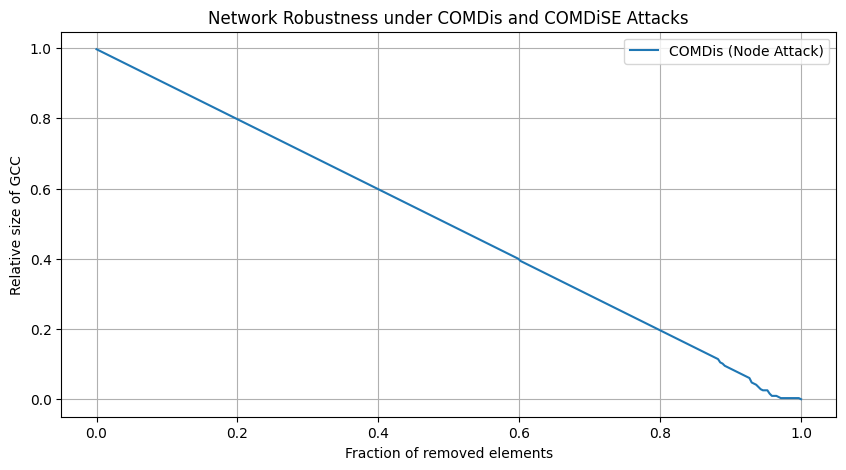

In [124]:
# 绘制攻击曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, len(node_curve)), node_curve, label='COMDis (Node Attack)')
# plt.plot(np.linspace(0, Q_edge, len(edge_curve)), edge_curve, label='COMDiSE (Edge Attack)')
plt.xlabel('Fraction of removed elements')
plt.ylabel('Relative size of GCC')
plt.title('Network Robustness under COMDis and COMDiSE Attacks')
plt.legend()
plt.grid()
plt.show()
